
## Лабораторная работа №1 "$\alpha-\beta-\gamma$ фильтр"

---



## Теоретические сведения
![](https://drive.google.com/uc?export=view&id=1i1TO_DAmF9dtOUOh6FOFfswo9RebCJO4)  
Рисунок 1 - Измерения расстояния до объекта локатором  

Рассмотрим динамическую систему, которая меняет свое состояние с течением времени. Возьмем пример с Лекции-01, где с помощью локатора отслеживается подвижный объект. Наложим для начала следующие ограничения: объект движется с постоянной скоростью в одномерном пространстве, объект удаляется от локатора. Локатор измеряет дальность до объекта с определенной постоянной частотой и для каждого момента времени ${t_1, t_2, ..., t_n}$ оценивается искомое расстояние до объекта $x_1, x_2, ..., x_n$, но из-за наличия погрешности, на выходе локатора мы имеем измеренные значения $z_1, z_2, ..., z_n$. Данные значение есть ни что иное как временной ряд - последовательность данных, отслеживаемых во времени. Временной ряд существенно отличается от простой выборки данных, так как при анализе учитывается взаимосвязь измерений со временем, а не только статистическое разнообразие и статистические характеристики выборки. К таким взаимосвязям измерений со временем относятся: автокорреляция в данных, наличие трендов, возможность прогнозирования и стационарность.  

Временные ряды, как случайные процессы, могут содержать в себе различные составляющие погрешностей и шумов - это и высокочастотный шум и систематическое смещение во времени и промахи с выбросами и многое другое. Желание избавиться или минимизировать шумы сенсоров или сигналов управления в соответствующих им временных рядах - это очевидное направление улучшения характеристик любой информационно-управляющей системы.  
Для решения данной задачи на практике применяются разнообразные фильтры и системы слежения.

**Цель работы** - исследование применимости тех или иных фильтров в зависимости от характера временных рядов.




### Генерация исходных данных
Представленный ниже код python генерирует исходные данные для описанного выше примера измерения дальности до подвижного объекта локатором. Погрешность измерения дальности распределена нормально (белый шум), СКО = 1 м

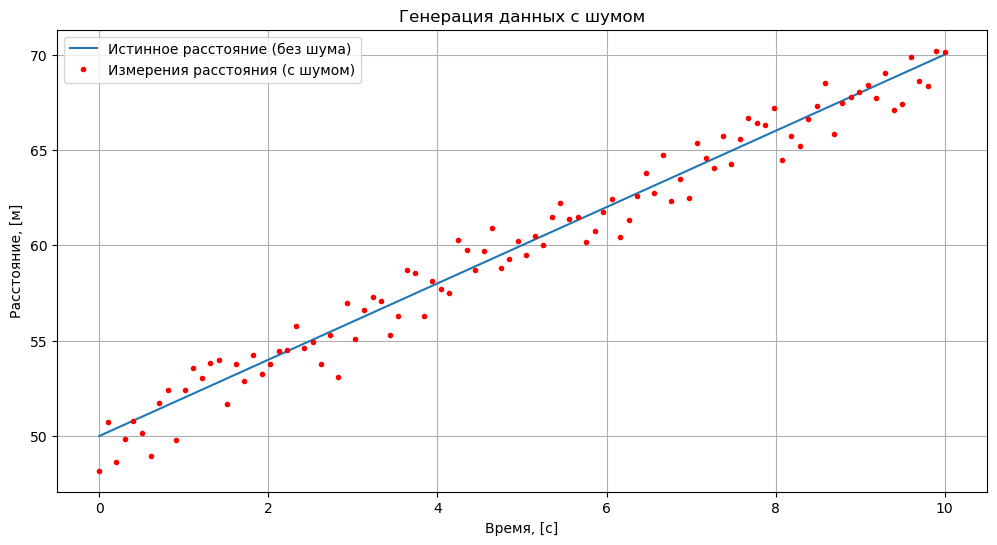

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры генерации данных
n_points = 100         # Количество точек данных
slope = 2              # Уклон (коэффициент при t, положительный - цель удаляется)
intercept = 50         # Смещение (начальное положение от локатора)
noise_std = 1          # Стандартное отклонение шума [м]

# Генерация временных меток
t = np.linspace(0, 10, n_points)  # Время от 0 до 10 секунд с 100 точками

# Генерация истинных данных (линейная зависимость от времени)
x_true = slope * t + intercept

# Добавление нормального шума к измерениям
z = x_true + np.random.normal(0, noise_std, n_points)

# Сохранение данных в файл
np.savetxt('data_complex.txt', np.vstack((x_true, z, np.zeros(n_points))).T, comments='', fmt='%f')

# Визуализация сгенерированных данных
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние (без шума)')
plt.plot(t, z, 'r.', label='Измерения расстояния (с шумом)')
plt.xlabel('Время, [c]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.grid()
plt.title('Генерация данных с шумом')
plt.show()


### Цифровые фильтры
**Цифровые фильтры** нашли широкое применение не только в электронике, но и в любой области, где требуется обработка сигналов: в спектральном анализе, обработке изображений, видео, речи, звука, а также в обработке данных измерений с различных датчиков и в других приложениях. Особое место занимают **линейные стационарные фильтры** благодаря их простоте и точности математического описания.

Основными характеристиками стационарных линейных дискретных фильтров являются:

*   *импульсная характеристика* — отклик фильтра на единичный импульс. Для КИХ фильтров она конечна, в то время как для БИХ фильтров она бесконечна.
*   *комплексная частотная характеристика* — показывает, как фильтр изменяет амплитуды и фазы различных частотных компонентов входного сигнала.
*   *амплитудно-частотная и фазочастотная характеристики* — показывают, как фильтр воздействует на амплитуды и фазы входного сигнала в зависимости от частоты.
*   *системная функция (передаточная функция)* — отношение выходного сигнала к входному в частотной области, описывающее поведение фильтра;
*   *разностное уравнение* — это еще одна важная характеристика цифровых фильтров, которая описывает поведение фильтра через связь между текущими и прошлыми значениями входного и выходного сигналов. Для цифрового фильтра разностное уравнение записывается в виде:
$y[n]+{a_1}y[n−1]+{a_2}y[n−2]+...={b_0}x[n]+{b_1}x[n−1]+{b_2}x[n−2]+...,$  
где: $𝑦[𝑛]$ — выходной сигнал фильтра в момент времени $𝑛$,  
$𝑥[𝑛]$ — входной сигнал в момент времени $𝑛$,  
$𝑎_𝑖$ и $𝑏_𝑖$ — коэффициенты фильтра.  

**КИХ и БИХ фильтры**

В цифровой обработке сигналов наиболее часто применяются два класса фильтров: фильтры с конечной импульсной характеристикой (КИХ) и фильтры с бесконечной импульсной характеристикой (БИХ).

*КИХ-фильтры* обладают конечной длиной импульсного отклика. Их основное преимущество заключается в стабильности, так как любой КИХ-фильтр всегда устойчив, и в точности фазочастотной характеристики (линейность фазы). Это делает их предпочтительными для задач, где важно сохранить форму сигнала, например, в обработке изображений и звука. Однако их вычислительная сложность может быть выше, особенно для узкополосных фильтров.

*БИХ-фильтры*, в свою очередь, обладают бесконечной импульсной характеристикой, поскольку их отклик на импульс продолжается бесконечно во времени. Они часто требуют меньших вычислительных ресурсов и могут реализовывать те же частотные характеристики с меньшим количеством коэффициентов по сравнению с КИХ-фильтрами. Однако они могут быть неустойчивыми, и их фазовая характеристика обычно нелинейна, что может искажать сигналы.


### Скользящее среднее (фильтр)
Фильтр скользящего среднего (moving average filter) — это простой и широко используемый цифровой линейный фильтр с конечной импульсной характеристикой (КИХ), который применяется для сглаживания временных рядов или сигналов и уменьшения уровня шума. Основная идея фильтра заключается в том, что он заменяет каждое значение сигнала средним значением нескольких соседних точек, тем самым устраняя резкие колебания и сглаживая шумы.  
Фильтр скользящего среднего вычисляет новое значение выходного сигнала как среднее арифметическое нескольких подряд идущих значений входного сигнала. Для фильтра с окном длиной $𝑀$, выходной сигнал в момент времени $𝑛$ определяется по следующей формуле:  
$y[n]=\frac{1}{M}\displaystyle\sum_{k=0}^{M-1}x[n-k]$

На рисунке 2 представлен фильтр 2-го порядка (M = 3).
![](https://drive.google.com/uc?export=view&id=1bxVFidqVbwLlHZPXqd_oCLxfrCoCLtaN)  
Рисунок 2 - фильтр скользящего среднего 2-го порядка

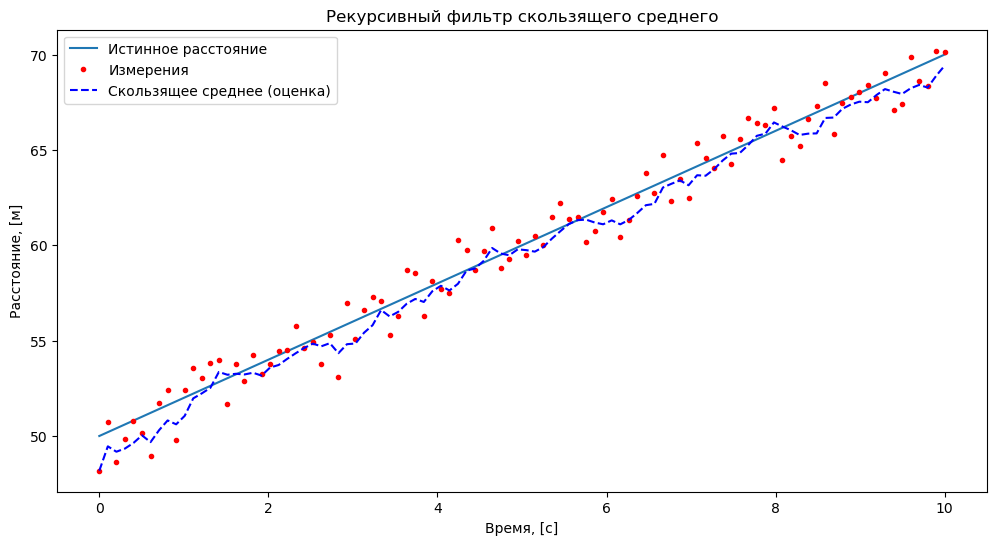

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def moving_average_filter(data):
  # Параметры фильтра скользящего среднего
  window_size = 5  # Размер окна

  # Функция для пошагового обновления фильтра скользящего среднего
  def moving_average_filter_step(window, new_value):
      window.append(new_value)
      if len(window) > window_size:
          window.popleft()  # Удаляем старые значения, если окно больше заданного размера
      return np.mean(window)

  # Инициализация фильтра
  y_ma_out = np.zeros(len(data))
  window = deque()

  # Применение рекурсивного фильтра скользящего среднего шаг за шагом
  for i in range(len(data)):
      y_ma_out[i] = moving_average_filter_step(window, data[i])

  return y_ma_out

# Загрузка данных из файла
data = np.loadtxt('data_complex.txt')
x_true = data[:, 0]  # Истинное состояние
z = data[:, 1]       # Измерения

y_ma_out = moving_average_filter(z)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние')
plt.plot(t, z, 'r.', label='Измерения')
plt.plot(t, y_ma_out, 'b--', label='Скользящее среднее (оценка)')
plt.xlabel('Время, [с]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.title('Рекурсивный фильтр скользящего среднего')
plt.show()

# Сохранение результатов
np.savetxt('sma_results.txt', np.vstack((t, x_true, z, y_ma_out)).T, comments='', fmt='%f')


### Медианный фильтр
Медианный фильтр — это ***нелинейный*** цифровой фильтр, который используется для устранения шумов и сглаживания сигналов, особенно эффективен при подавлении импульсных помех. В отличие от фильтра скользящего среднего, который использует среднее арифметическое, медианный фильтр заменяет каждую точку сигнала медианным значением набора соседних точек, что делает его более устойчивым к выбросам и резким пиковым значениям.
Разностное уравнение фильтра:  
$y[n]=median(x[n−k],…,x[n],…,x[n+k])$

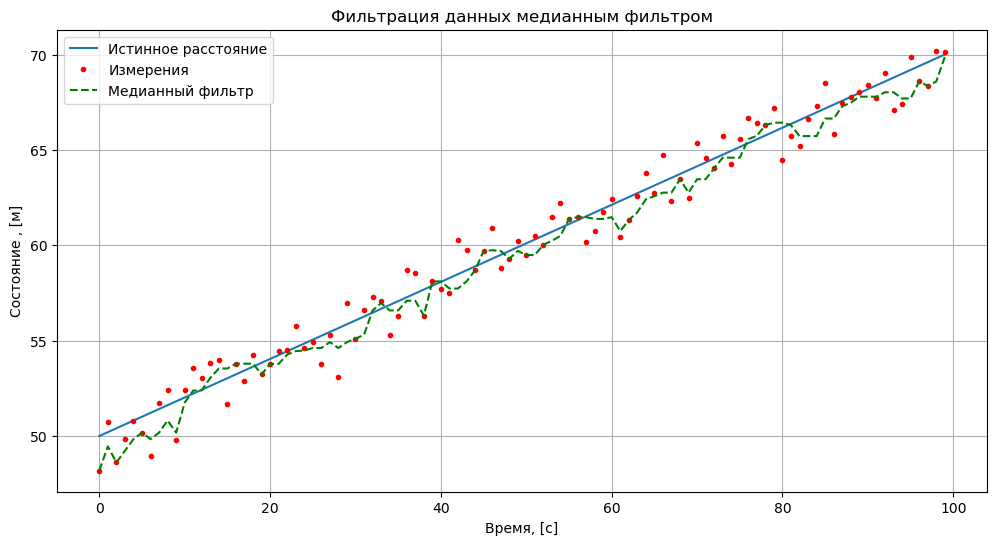

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

def median_filter(data):

  # Параметры медианного фильтра
  window_size = 5  # Размер окна

  # Функция для пошагового обновления медианного фильтра
  def median_filter_step(window, new_value):
      window.append(new_value)
      if len(window) > window_size:
          window.popleft()  # Удаляем старое значение, если окно больше заданного размера
      return np.median(window)


  # Инициализация фильтра
  x_median_step = np.zeros(len(data))
  window = deque()

  # Применение рекурсивного медианного фильтра шаг за шагом
  for i in range(len(data)):
      x_median_step[i] = median_filter_step(window, data[i])

  return x_median_step

# Загрузка данных из файла
data = np.loadtxt('data_complex.txt')
x_true = data[:, 0]  # Истинное состояние
z = data[:, 1]       # Измерения

x_median_step = median_filter(z)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(x_true, label='Истинное расстояние')
plt.plot(z, 'r.', label='Измерения')
plt.plot(x_median_step, 'g--', label='Медианный фильтр')
plt.xlabel('Время, [с]')
plt.ylabel('Состояние , [м]')
plt.legend()
plt.grid()
plt.title('Фильтрация данных медианным фильтром')
plt.show()

# Сохранение результатов
np.savetxt('median_results.txt', np.vstack((t, x_true, z, x_median_step)).T, comments='', fmt='%f')

### Экспоненциальный фильтр
Экспоненциальный фильтр (или экспоненциальное сглаживание, Exponential Moving Average, EMA) — это линейный рекурсивный фильтр с бесконечной импульсной характеристикой (БИХ). В отличие от фильтра скользящего среднего, экспоненциальный фильтр придаёт больший вес недавним значениям сигнала, а более старые данные экспоненциально уменьшаются по важности. Это делает его более чувствительным к последним изменениям и менее подверженным задержке по сравнению с фильтром скользящего среднего. Разностное уравнение для фильтра имеет вид:    
$y[n]=α⋅x[n]+(1−α)⋅y[n−1]$  
где $y[n]$ — это отфильтрованное значение в отсчет времени $n$, $x[n]$ — текущее измерение, а $𝛼$ — коэффициент сглаживания (обычно в диапазоне $0<𝛼≤1$). Если $𝛼$ близко к 1, то фильтр больше "полагается" на текущее значение входного сигнала, что делает его более "быстрым", но менее сглаживающим.
Если $𝛼$ близко к 0, фильтр больше "полагается" на предыдущие значения выходного сигнала, что делает его более "медленным" и даёт более сильное сглаживание.

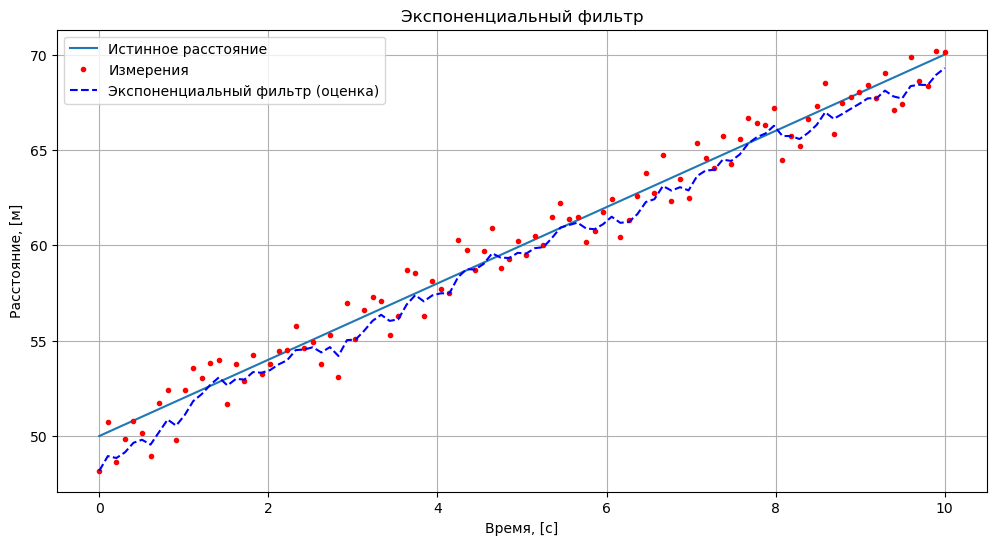

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры экспоненциального фильтра
alpha = 0.3  # Коэффициент сглаживания (0 < alpha <= 1)

# Функция для экспоненциального фильтра
def exponential_filter(data, alpha):
    exp_filt = np.zeros_like(data)
    exp_filt[0] = data[0]  # Инициализация с первого значения

    for i in range(1, len(data)):
        exp_filt[i] = alpha * data[i] + (1 - alpha) * exp_filt[i-1]  # Экспоненциальное сглаживание

    return exp_filt

# Загрузка данных из файла
data = np.loadtxt('data_complex.txt')
x_true = data[:, 0]  # Истинное состояние
z = data[:, 1]       # Измерения

# Применение экспоненциального фильтра
x_exp = exponential_filter(z, alpha)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние')
plt.plot(t, z, 'r.', label='Измерения')
plt.plot(t, x_exp, 'b--', label='Экспоненциальный фильтр (оценка)')
plt.xlabel('Время, [с]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.grid()
plt.title('Экспоненциальный фильтр')
plt.show()

# Сохранение результатов
np.savetxt('exp_results.txt', np.vstack((t, x_true, z, x_exp)).T, comments='', fmt='%f')


### Фильтр $\alpha-\beta-\gamma$
Представленные выше цифровые фильтры удобны своей простотой и в определенных условиях их применения может быть достаточно. Можно обратить внимание на то, что данные фильтры никак не учитывают динамику рассматриваемой системы и для них входные данные - это лишь временной ряд, никак не привязанный к каким-либо объектам. В нашем же примере, описанным в начале лабораторной работы, мы имеет дело с определенной динамической системой, для которой мы может аналитически описать модель движения объекта. Так, скорость движения объекта определяется по формуле:  
$\dot{x}=\upsilon=\frac{dx}{dt}$  
А расстояние до цели - $x = x_0+\dot{x}Δt$  

Наша модель - дискретная (т.к. измерения расстояния у нас дискретные), то расстояние до объекта и его скорость можно описать следующими уравнениями:  
$x_{n+1}=x_n+\Delta t\dot{x}_n$  
$\dot{x}_{n+1}=\dot{x}_n$

С учетом предполагаемой модели объекта мы можем не просто фильтровать приходящие данные (временные ряды), но и прогнозировать предстоящее состояние системы за счет предыдущего состояния и измеряемых значений. Визуально это можно представить следующим образом (см. рисунок 3).

![](https://drive.google.com/uc?export=view&id=1BqRnJfylC0LoFIbtZcsXX2aThZRb2N9r)  
Рисунок 3 - Состояние системы с учетом динамической модели

При этом, на рисунке используются следующие обозначения:  

*   $x_n$ - истинное значение расстояния до объекта в отсчет $n$
*   $z_n$ - измеренное значение расстояния в отсчет $n$
*   $\hat{x}_{n,n}$ - оценка (estimate) расстояния в отсчет $n$, сделанная после (с учетом) приема измеренного значения $z_n$
*   $\hat{x}_{n+1,n}$ - оценка расстояния в следующий отсчет $(n+1)$, то есть предсказываемое значение или эксстраполируемое
*   $\hat{x}_{n-1,n-1}$ - оценка (estimate) расстояния в отсчет $(n-1)$ (предыдущий), сделанная после (с учетом) приема измеренного значения $z_{n-1}$
*   $\hat{x}_{n,n-1}$ - предыдущее предсказанное значение (в отсчет $(n-1)$ - оценка расстояния в отсчет $n$ (до измерения)

Уравнение обновления состояния модели (State Update Equation, вывод будет на лекции) в таком случае можно записать в следующем виде:  
$\hat{x}_{n,n}=\hat{x}_{n,n-1}+\alpha\left(z_n-\hat{x}_{n,n-1}\right)$
![](https://drive.google.com/uc?export=view&id=1jqd0qgRuiWlD0-iaY1OklhlhY9jCqtTk)  
Рисунок 4 - State Update Equation

Разница в скобках называется "measurement residual" и именно в них содержится новая информация, которая итерационно (рекурсивно) исправляет нашу оценку расстояния.

Данный рекурсивный механизм - основа соотвествующих фильтров: от простейшего $\alpha-\beta$ до расширенного фильтра Калмана.

Для нашей задачи подойдет альфа-бета фильтр, которые основан на идее прогнозирования положения и скорости объекта, а также корректировки этих прогнозов на основе новых измерений. Он применяет два параметра — 𝛼 и 𝛽, которые определяют, насколько сильно обновления выходных значений фильтра зависят от текущих измерений. Эти параметры представляют собой коэффициенты корректировки для позиции и скорости соответственно.

Описанные выше уравнения движения $x_{n+1}$ и $\dot{x}_{n+1}$ называются Уравнениями экстраполяции (State Extrapolation Equation, Transition Equation или Prediction Equation)/

А вот уравнение обновления состояния (State Update Equation) в альфа-бета фильтре записываются соответсвенно:
*   для скорости - $\hat{\dot{x}}_{n,n}=\hat{\dot{x}}_{n,n-1}+\beta\left(\frac{z_n-\hat{x}_{n,n-1}}{\Delta t}\right)$  
*   для позиции - $\hat{x}_{n,n}=\hat{x}_{n,n-1}+\alpha\left(z_n-\hat{x}_{n,n-1}\right)$

$α$ и $𝛽$ определяют, насколько сильно фильтр будет реагировать на новые данные:
*   если $𝛼$ близко к 1, фильтр будет быстро следовать за измерениями, но также будет более чувствителен к шумам.
*   если $𝛼$ близко к 0, фильтр будет более инертным и сглаживать шумы, но медленнее реагировать на изменения.

Аналогично, значение $𝛽$ определяет, насколько быстро изменится оценка скорости.  
Обычно значения $𝛼$ выбираются в диапазоне от 0.2 до 0.8, а
$𝛽$ — от 0.1 до 0.4, но их настройка зависит от характеристик шума.

## Задание лабораторной работы  


1.   Напишите исходный код для $\alpha-\beta$ фильтра и проверьте корректность его работы на генерируемых данных путем ее визуализации, как в остальных фильтрах, а также сохраните результирующий файл с отфильтрованными данными.
2.   Реализуйте $\alpha-\beta-\gamma$ фильтр  и проверьте его работы на данных.
3.   Напишите исходный код, который бы сравнивал между собой погрешность отфильтрованных данных разными алгоритмами. В качестве метрики сравнения возьмите СКО. Опишите, какой из фильтров дает наилучший результат.
4.   Напишите новый скрипт по генерации данных при наличии выбросов, сравните результаты работы всех алгоритмов. Дайте оценку, изменились ли результаты по лучшему фильтру.
5.   Напишите новый скрипт по генерации данных, но измените траекторию движения объекта (по вариантам). Дайте оценку, изменились ли результаты по лучшему фильтру.
6.   Напишите выводы по проделанной работе



## Выполнение лабораторной работы  
### 1. Реализация $\alpha-\beta$ фильтра
Напишите программу на языке python, которая бы реализовывала

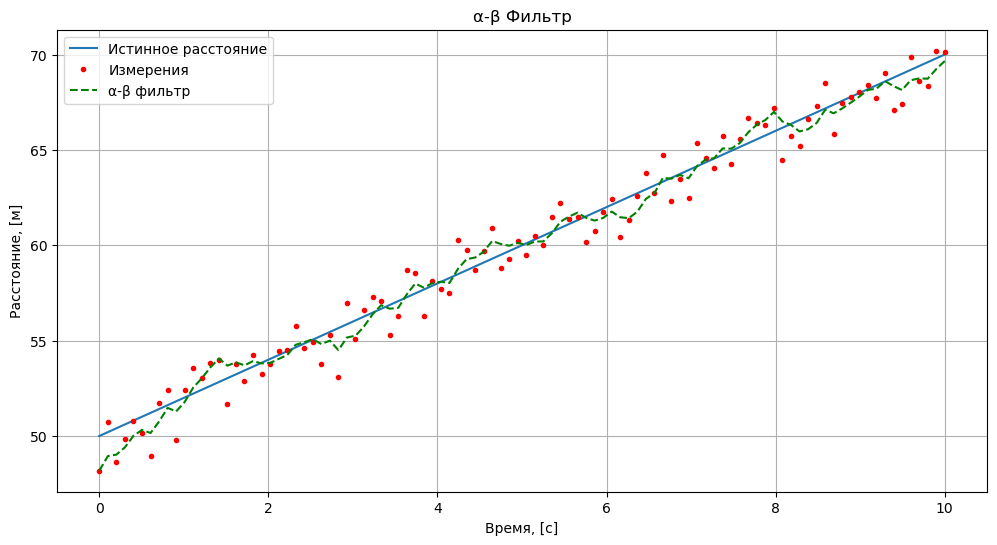

In [5]:
# prompt: Implement α−β  filter

import numpy as np
import matplotlib.pyplot as plt

# Parameters for alpha-beta filter
alpha = 0.3
beta = 0.1
dt = t[1] - t[0]  # Assuming constant time step

def alpha_beta_filter(data, alpha, beta, dt):

  # Initialize filter variables
  x_hat = np.zeros(n_points)
  v_hat = np.zeros(n_points)

  # Apply alpha-beta filter
  x_hat[0] = data[0]  # Initial estimate of position
  for i in range(1, n_points):
      # Prediction step
      x_hat_pred = x_hat[i-1] + dt * v_hat[i-1]
      v_hat_pred = v_hat[i-1]

      # Update step
      x_hat[i] = x_hat_pred + alpha * (data[i] - x_hat_pred)
      v_hat[i] = v_hat_pred + beta * (data[i] - x_hat_pred) / dt

  return x_hat

x_hat = alpha_beta_filter(z, alpha=alpha, beta=beta, dt=dt)

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние')
plt.plot(t, z, 'r.', label='Измерения')
plt.plot(t, x_hat, 'g--', label='α-β фильтр')
plt.xlabel('Время, [с]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.grid()
plt.title('α-β Фильтр')
plt.show()

# Save results
np.savetxt('alpha_beta_results.txt', np.vstack((t, x_true, z, x_hat)).T, comments='', fmt='%f')

### 2. Реализация $\alpha-\beta-\gamma$ фильтра

NameError: name 'x_hat_gamma' is not defined

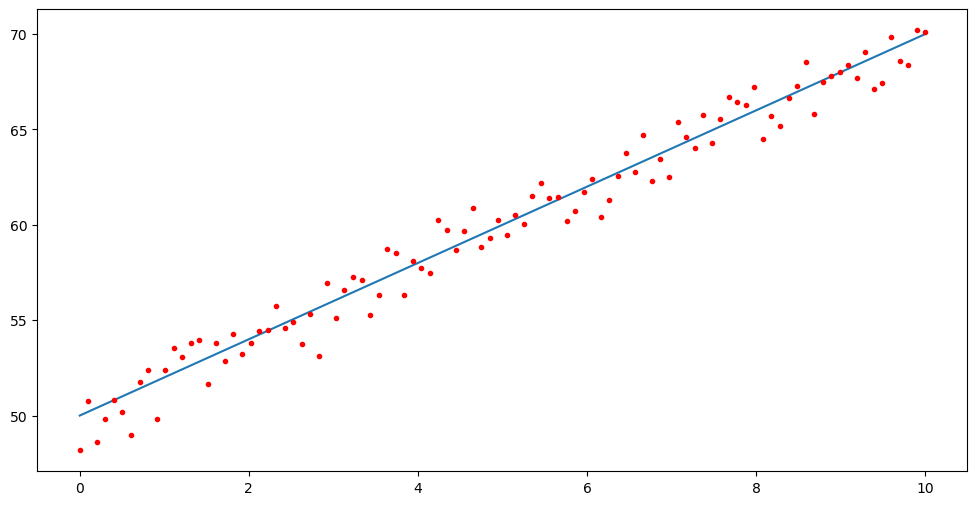

In [6]:
# prompt: Implement α−β−γ  filter

# Parameters for alpha-beta-gamma filter
gamma = 0.01

def alpha_beta_gamma_filter(data, alpha, beta, gamma, dt):

  # Initialize filter variables
  x_hat_gamma = np.zeros(len(data))
  v_hat_gamma = np.zeros(len(data))
  a_hat = np.zeros(len(data))  # Initialize acceleration estimate

  # Apply alpha-beta-gamma filter
  x_hat_gamma[0] = data[0]  # Initial estimate of position
  v_hat_gamma[0] = 0 # Initial estimate of velocity
  for i in range(1, n_points):
      # Prediction step
      x_hat_pred = x_hat_gamma[i-1] + dt * v_hat_gamma[i-1] + 0.5 * dt**2 * a_hat[i-1]
      v_hat_pred = v_hat_gamma[i-1] + dt * a_hat[i-1]
      a_hat_pred = a_hat[i - 1]

      # Update step
      x_hat_gamma[i] = x_hat_pred + alpha * (z[i] - x_hat_pred)
      v_hat_gamma[i] = v_hat_pred + beta * (z[i] - x_hat_pred) / dt
      a_hat[i] = a_hat_pred + gamma * ((z[i] - x_hat_pred) / (0.5 * dt**2))

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние')
plt.plot(t, z, 'r.', label='Измерения')
plt.plot(t, x_hat_gamma, 'm--', label='α-β-γ фильтр')
plt.xlabel('Время, [с]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.grid()
plt.title('α-β-γ Фильтр')
plt.show()

# Save results
np.savetxt('alpha_beta_gamma_results.txt', np.vstack((t, x_true, z, x_hat_gamma)).T, comments='', fmt='%f')

### 3. Сравнение результатов

In [7]:
# prompt: Напишите исходный код, который бы сравнивал между собой погрешность отфильтрованных данных разными алгоритмами. В качестве метрики сравнения возьмите СКО. Опишите, какой из фильтров дает наилучший результат.

# Calculate standard deviations for each filter
std_ma = np.std(y_ma_out - x_true)
std_median = np.std(x_median_step - x_true)
std_exp = np.std(x_exp - x_true)
std_alpha_beta = np.std(x_hat - x_true)
std_alpha_beta_gamma = np.std(x_hat_gamma - x_true)

# Print the standard deviations
print(f"Standard Deviation (Moving Average): {std_ma}")
print(f"Standard Deviation (Median): {std_median}")
print(f"Standard Deviation (Exponential): {std_exp}")
print(f"Standard Deviation (Alpha-Beta): {std_alpha_beta}")
print(f"Standard Deviation (Alpha-Beta-Gamma): {std_alpha_beta_gamma}")

# Find the filter with the lowest standard deviation
stds = {
    "Moving Average": std_ma,
    "Median": std_median,
    "Exponential": std_exp,
    "Alpha-Beta": std_alpha_beta,
    "Alpha-Beta-Gamma": std_alpha_beta_gamma
}
best_filter = min(stds, key=stds.get)
print(f"\nThe best filter is {best_filter} with a standard deviation of {stds[best_filter]}")

Standard Deviation (Moving Average): 0.3291348390366516
Standard Deviation (Median): 0.44455824986716513
Standard Deviation (Exponential): 0.3408934514781074
Standard Deviation (Alpha-Beta): 0.4276293030047095
Standard Deviation (Alpha-Beta-Gamma): 0.4664169485567596

The best filter is Moving Average with a standard deviation of 0.3291348390366516


### 4. Генерация исходных данных при наличии выбросов
Напишите исходный код, добавляющий выбросы в уже сгенерированный файл или генерирующий новый файл, в котором сохраняется истинное значение положения объекта и добавляются высокочастотный шум (белый, нормально распределенный) с увеличенным СКО = 3 м, а также не менее 10 выбросов в диапазоне 5 - 10 м.

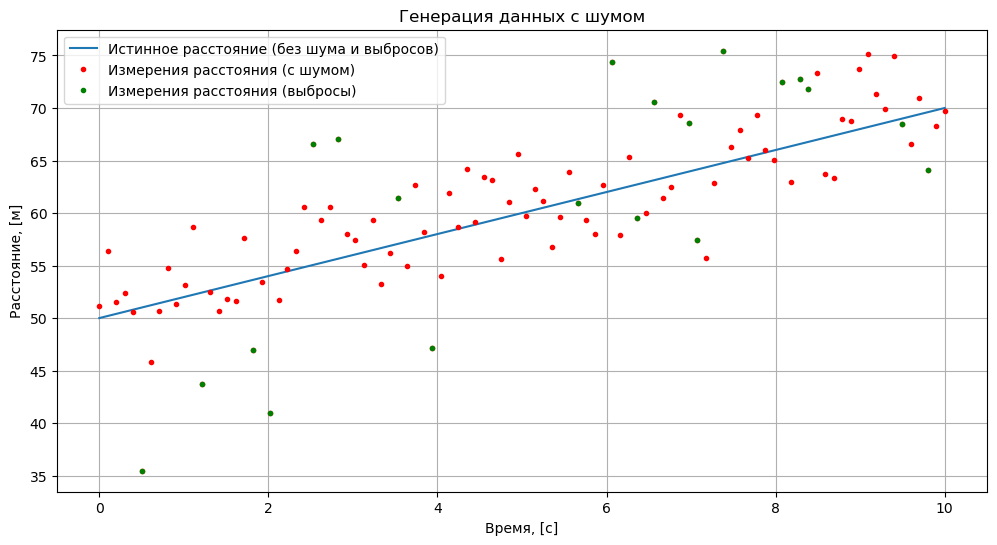

In [8]:
# prompt: Напишите исходный код, генерирующий новый файл, в котором сохраняется истинное значение положения объекта и добавляются высокочастотный шум (белый, нормально распределенный) с увеличенным СКО = 3 м, а также не менее 10 выбросов в диапазоне 5 - 10 м.
import math

noise_std = 3          # Стандартное отклонение шума [м]

# Добавление нормального шума к измерениям
z = x_true + np.random.normal(0, noise_std, n_points)

# Add outliers
def add_outliers(data, num_outliers, outlier_range):
  outlier_indices = np.random.choice(len(data), num_outliers, replace=False)
  neg_outlier_values = np.random.uniform(-outlier_range[1], -outlier_range[0], math.floor(num_outliers / 2))
  pos_outlier_values = np.random.uniform(outlier_range[0], outlier_range[1], math.floor(num_outliers / 2))
  neg_indices = outlier_indices[:math.floor(len(outlier_indices)/2)]
  pos_indices = outlier_indices[math.floor(len(outlier_indices)/2):]

  data[neg_indices] = data[neg_indices] + neg_outlier_values
  data[pos_indices] = data[pos_indices] + pos_outlier_values

  return outlier_indices

outliers = np.zeros(n_points)
outlier_indices = add_outliers(outliers, num_outliers=20, outlier_range=(5, 10))
z += outliers

# Save the new data to a file
np.savetxt('data_with_outliers.txt', np.vstack((x_true, z)).T, fmt='%f', comments='')

# Визуализация сгенерированных данных
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние (без шума и выбросов)')
plt.plot(t, z, 'r.', label='Измерения расстояния (с шумом)')
plt.plot(t[outlier_indices], z[outlier_indices], 'g.', label='Измерения расстояния (выбросы)')
plt.xlabel('Время, [c]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.grid()
plt.title('Генерация данных с шумом')
plt.show()

### 5. Генерация данных по варианту
Напишите исходный код, который бы генерировал исходные данные движения объекта с зашумлением по варианту, представленному в таблице ниже.

| Вариант | Сигнал | Тип погрешности | Фамилии |
|---------|--------|----------|----|
| 1 | sin    | белый шум и выбросы   | Андронов, Голев, Миронов, Харламов |
| 2 | трапеция | равномерно распределенный | Барыбин, Елманов, Слесарев, Чугунов |
| 3 | cos | белый шум и выбросы | Волков, Зинченко, Смирнов |
| 4 | треугольный | равномерно распределенный и выбросы | Гасанов, Литвинов, Токарев |


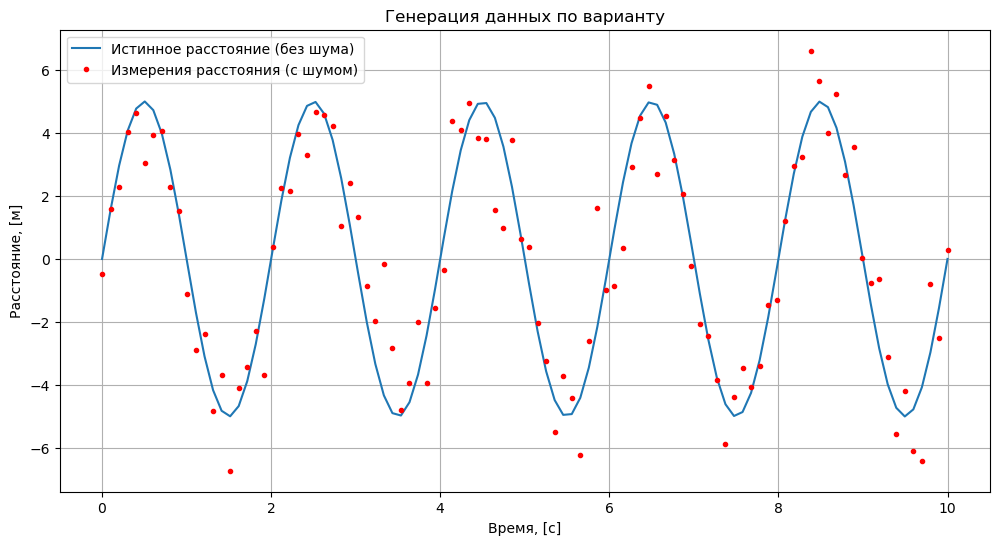

In [9]:
# prompt: Напишите исходный код, который бы генерировал исходные данные движения объекта по синусу.

# Generate true object trajectory (sine wave)
amplitude = 5
frequency = 0.5
x_true = amplitude * np.sin(2 * np.pi * frequency * t)

# Add noise (white noise with normal distribution)
noise_std = 1  # Standard deviation of the noise
noise = np.random.normal(0, noise_std, n_points)
z = x_true + noise

outliers = np.zeros(n_points)
add_outliers(outliers, num_outliers=20, outlier_range=(noise_std * 1.6, noise_std * 2))
z += outliers

# Save data to a file
np.savetxt('data_sine.txt', np.column_stack((x_true, z)), fmt='%f')

# Visualize the generated data
plt.figure(figsize=(12, 6))
plt.plot(t, x_true, label='Истинное расстояние (без шума)')
plt.plot(t, z, 'r.', label='Измерения расстояния (с шумом)')
plt.xlabel('Время, [c]')
plt.ylabel('Расстояние, [м]')
plt.legend()
plt.grid()
plt.title('Генерация данных по варианту')
plt.show()

### 6. Выводы по проделанной работе
Напишите выподы по данной работе, что можно сказать о исследовании применимости тех или иных фильтров в зависимости от характера временных рядов. Приведите небольшую сравнительную таблицу характеристик фильтров в зависимости от данных временного ряда.

## Защита лабораторной работы
Продемонстрируйте преподавателю работу написанных программ и сделанные выводы, ответьте на дополнительные вопросы и выполните доп. задания по требованию преподавателя.